<a href="https://colab.research.google.com/github/codeAbhishek/Chat-Bot/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 376 kB 64.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b63bfb744b86aa8f396d9523956c33047e05a668735ce6b7c2f9f029d95797a3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=afe39f0ab1a6d46d11ba777d2b5f3f23da273a3ce79a8608d547fda8daef906e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


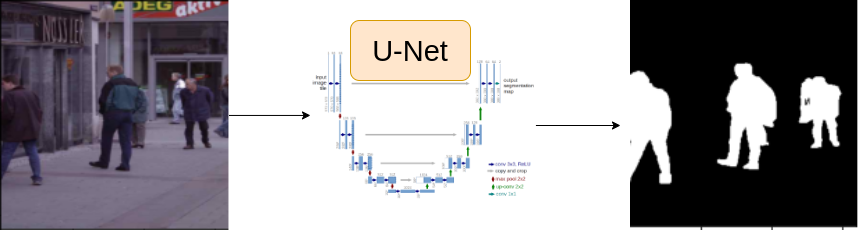

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'content'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


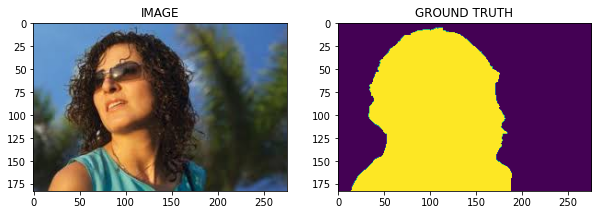

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [31]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [32]:
def get_train_augs():
  return A.Compose([ 
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([ 
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [14]:
from torch.utils.data import Dataset

In [45]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      # (h, w, c) -> (c, h, w)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask


In [46]:
trainset = SegmentationDataset(train_df, get_train_augs())


In [47]:
validset = SegmentationDataset(valid_df, get_valid_augs())

In [48]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


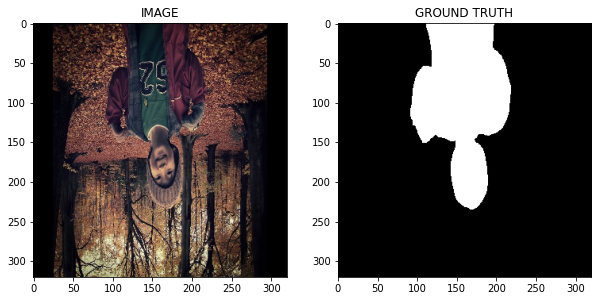

In [52]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [54]:
from torch.utils.data import DataLoader

In [55]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [56]:
print(f"total number of batches in trainloader : {len(trainloader)}")
print(f"total number of batches in validloader : {len(validloader)}")

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [59]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [60]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [61]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet( 
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3, 
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits 

In [62]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [69]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [73]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [74]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [75]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


SAVED MODEL
Epoch : 1 train_loss : 0.40745917359987893 Valid_loss : 0.8635704815387726


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED MODEL
Epoch : 2 train_loss : 0.3496831476688385 Valid_loss : 0.37841539829969406


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


SAVED MODEL
Epoch : 3 train_loss : 0.27679304977258046 Valid_loss : 0.27168479561805725


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


SAVED MODEL
Epoch : 4 train_loss : 0.24736612935860952 Valid_loss : 0.2460808977484703


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 5 train_loss : 0.21611090997854868 Valid_loss : 0.29275815561413765


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED MODEL
Epoch : 6 train_loss : 0.18495670855045318 Valid_loss : 0.20461566001176834


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch : 7 train_loss : 0.20084753533204397 Valid_loss : 0.2462562657892704


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 8 train_loss : 0.20171212355295817 Valid_loss : 0.22716157510876656


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 9 train_loss : 0.16817846099535624 Valid_loss : 0.22908767871558666


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 10 train_loss : 0.13562723646561306 Valid_loss : 0.21454218216240406


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch : 11 train_loss : 0.1263737643758456 Valid_loss : 0.20644176378846169


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 12 train_loss : 0.15997774402300516 Valid_loss : 0.26376114413142204


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 13 train_loss : 0.15864471793174745 Valid_loss : 0.23274682089686394


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch : 14 train_loss : 0.12997467567523321 Valid_loss : 0.20503593236207962


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 15 train_loss : 0.13723486214876174 Valid_loss : 0.2081521935760975


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED MODEL
Epoch : 16 train_loss : 0.13487024356921515 Valid_loss : 0.18228190392255783


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 17 train_loss : 0.13537180920441946 Valid_loss : 0.20123985223472118


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 18 train_loss : 0.11956116805473964 Valid_loss : 0.19223907962441444


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 19 train_loss : 0.12384635905424754 Valid_loss : 0.22247589752078056


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 20 train_loss : 0.12229147404432297 Valid_loss : 0.20632054656744003


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 21 train_loss : 0.15136574407418568 Valid_loss : 0.2605120297521353


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


SAVED MODEL
Epoch : 22 train_loss : 0.09579939941565195 Valid_loss : 0.15034399554133415


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch : 23 train_loss : 0.09191815281907717 Valid_loss : 0.18933141604065895


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 24 train_loss : 0.08801275740067165 Valid_loss : 0.19030338153243065


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED MODEL
Epoch : 25 train_loss : 0.08688696771860123 Valid_loss : 0.14407388493418694


# Task 9 : Inference

In [77]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, W, H) -> (1, C, W, H)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

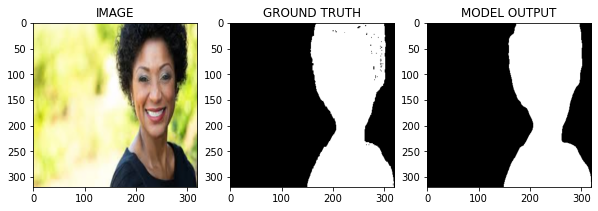

In [78]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))